In [1]:
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import itertools
import re
import sys
import pprint
import statistics
import numpy as np
import seaborn as sns

module_dir = "./scripts/"
sys.path.append(module_dir)

import balticEdited as bt
# import reassortment_rates_host as rea
import reassortment_utils as rea

#use treesort_prepper to prep files and run treesort

#run before_plotting on treesort trees so then it is ready for plotting with baltic


In [2]:
def load_tree(path,filename,region_dict, host_dict):
    nwkPath=f"{path}/{filename}"
    mytree = bt.loadNewick(nwkPath, absoluteTime= False)
    mytree = traits(mytree, region_dict, host_dict)
    return(mytree)


def load_clock(blength_file):

    with open(blength_file) as f:
        data = json.load(f)

    rate = data["clock"]["rate"]
    
    return rate

def load_trait_data(traits_file):

    with open(traits_file) as f:
        data = json.load(f)
    
    region_dict = {}
    host_dict = {}

    for node_name, node_data in data['nodes'].items():
        region_dict[node_name] = node_data.get("region")
        host_dict[node_name] = node_data.get("host")

    return(region_dict, host_dict)

def traits(tree, region_dict, host_dict):
    
    for k in tree.Objects:
        if k.branchType == "node":
            k.traits["region"] = region_dict.get(k.traits["label"])
            k.traits["host"] = host_dict.get(k.traits["label"])
        if k.branchType == "leaf":
            k.traits["region"] = region_dict.get(k.name)
            k.traits["host"] = host_dict.get(k.name)
    return(tree)


region_colors = {
    'Europe': '#9e0142',
    'Japan Korea': '#d53e4f',
    'Southeast Asia': '#f46d43',
    'West Asia': '#fdae61',
    'South America': '#fee08b',
    'South Asia' : '#e6f598',
    'Africa': '#abdda4',
    'China': '#66c2a5',
    'Oceania': '#3288bd',
    'North America': '#5e4fa2'
}

host_colors = {
    'Avian': '#d53e4f',
    'Camel': '#f46d43',
    'Equine': '#fdae61',
    'Feline': '#fee08b',
    'Seal': '#f7f7b2',
    'Canine': '#e6f598',
    'Human': '#abf0a4',
    'Mink': '#66c2a5',
    'Swine': '#3288bd'
}



In [3]:
ref = "mp"

clock_rate = load_clock(f"./preprepped/branch-lengths_h3nx_{ref}.json")
tree_dict = {}

for i in range(1,6):
    
    path = f'trees_{i}'
    filename = 'for_plotting.nwk'
    region_dict, host_dict = load_trait_data(f"trees_{i}/traits_{i}/traits_h3nx_{ref}.json")
    mytree = load_tree(path, filename, region_dict, host_dict)
    
    tree_dict[f"trees_{i}"] = mytree


In [4]:
print(tree_dict)


{'trees_1': <balticEdited.tree object at 0x1485a9960>, 'trees_2': <balticEdited.tree object at 0x14967f490>, 'trees_3': <balticEdited.tree object at 0x14aa47160>, 'trees_4': <balticEdited.tree object at 0x14f41ae30>, 'trees_5': <balticEdited.tree object at 0x14f41af20>}


In [5]:
def plot_host_reassort(mytree, output_path, fig_name):

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: 'red' if k.traits['host'] == 'ancestor' else host_colors.get(k.traits['host'])
    
    func_width = lambda k: 7 if k.traits['is_reassorted'] else 3 #ha

    # func_width = lambda k: 10 if k.traits['is_reassorted'] else 2 #na

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = func_width)
    
    def s_func_x(k):
        
        mapping = {
            True: 250,
            False: 0
        }

        return mapping[k.traits['is_reassorted']]

    def s_func_o(k):
        
        mapping = {
            True: 0,
            False: 50
        }
        
        return mapping[k.traits['is_reassorted']]
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_o,
                   colour=color_by,
                   outline_colour='#3f3f3f',
                   zorder=3,
                   marker='o'
                     )

    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size=s_func_x,
                   colour=color_by,
                   zorder=4,
                   marker='X',
                   outline=False,
                   edgecolor='#3f3f3f'
                     )

    # target_func = lambda k: k.is_leaf() or k.is_node()  # Which branches will be annotated
    # text_func = lambda k: k.traits['rea'] if k.traits['is_reassorted'] else ""

    # mytree.addText(ax, x_attr=x_attr, target=target_func, text=text_func, size = '15')

    legend_handles = [Patch(color=color, label=host) for host, color in host_colors.items()]

    legend = ax.legend(handles=legend_handles, title="$\\bf{Hosts}$", loc="lower left", fontsize='25')
    plt.setp(legend.get_title(),fontsize=25)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=25,size=15, width=2,color='grey')
    fig.tight_layout()
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    else:
        pass
    
    plt.savefig(f"{output_path}/{fig_name}")
    
    plt.show()

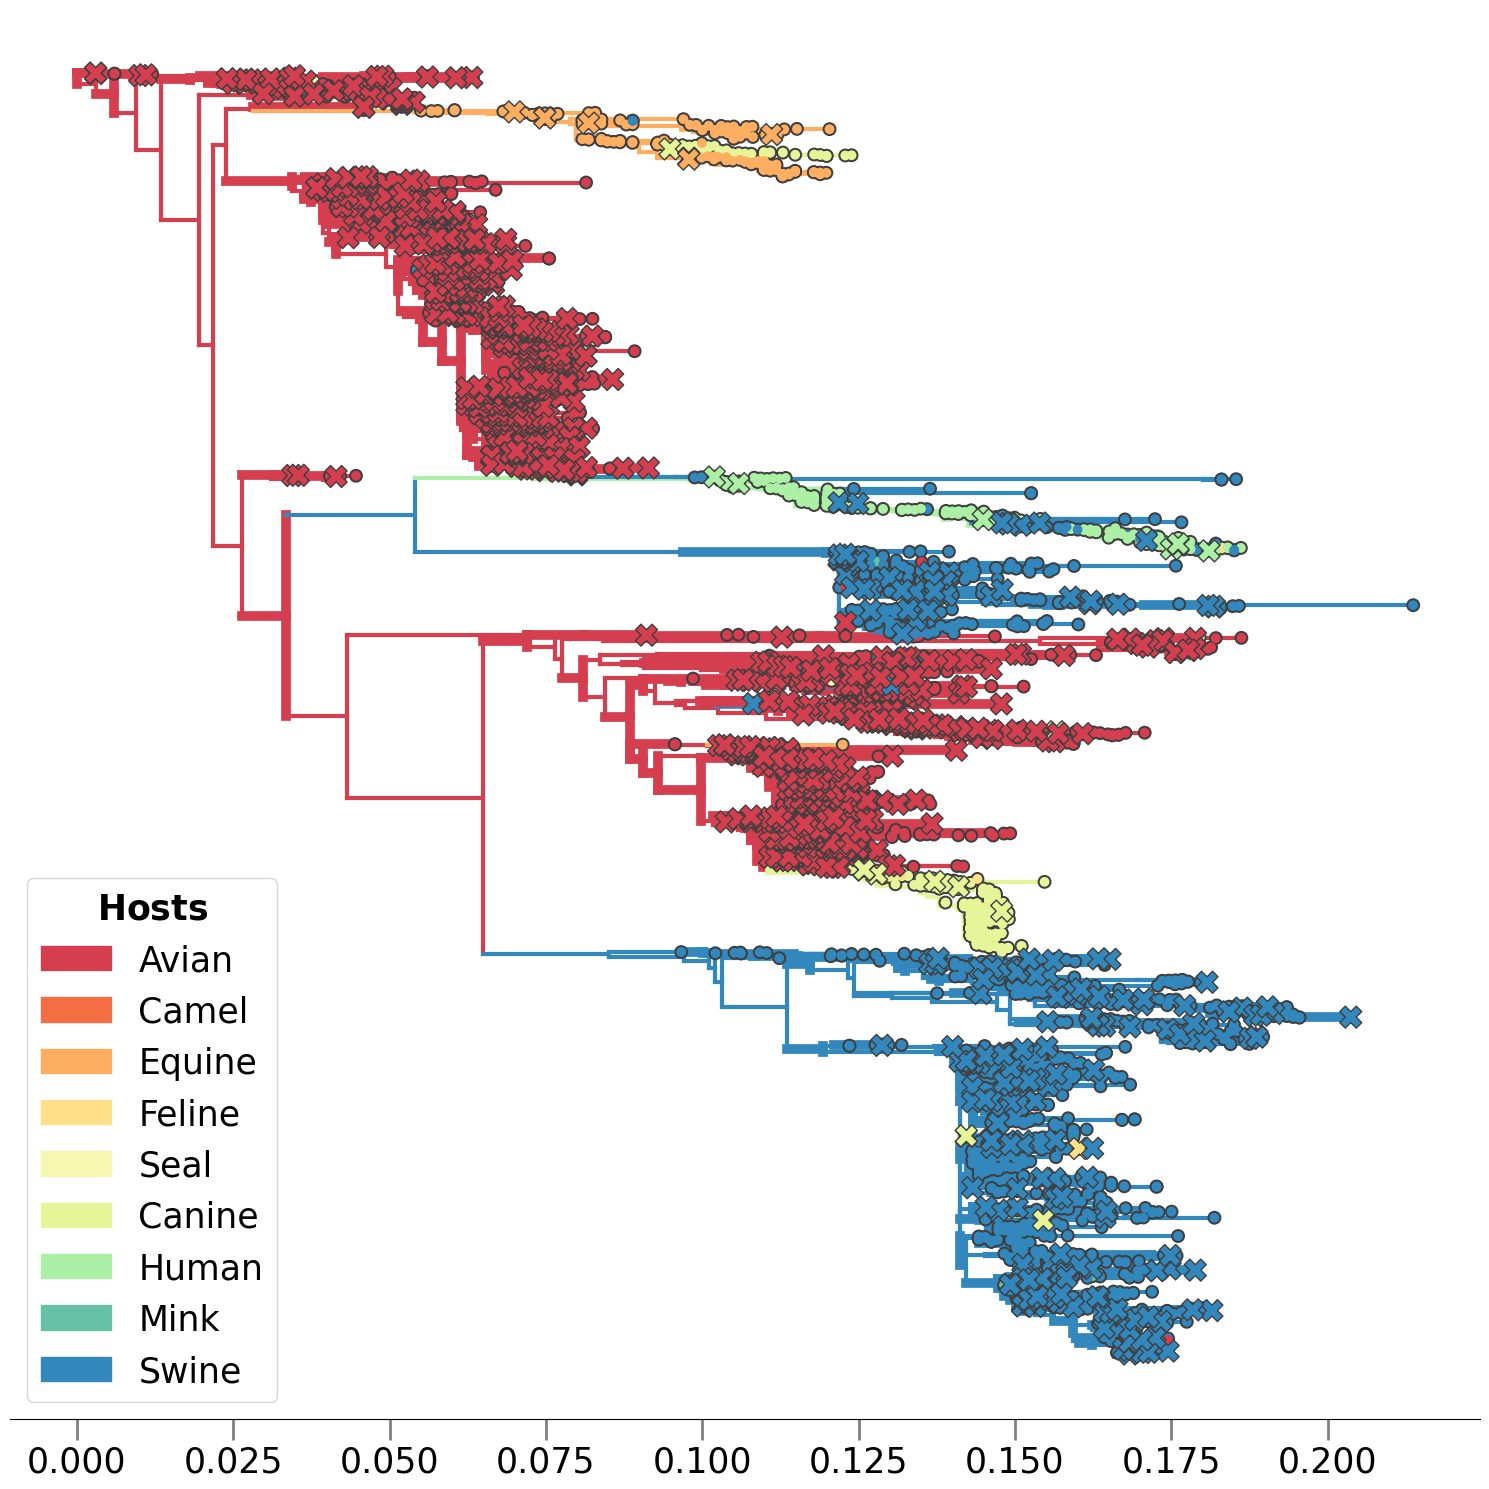

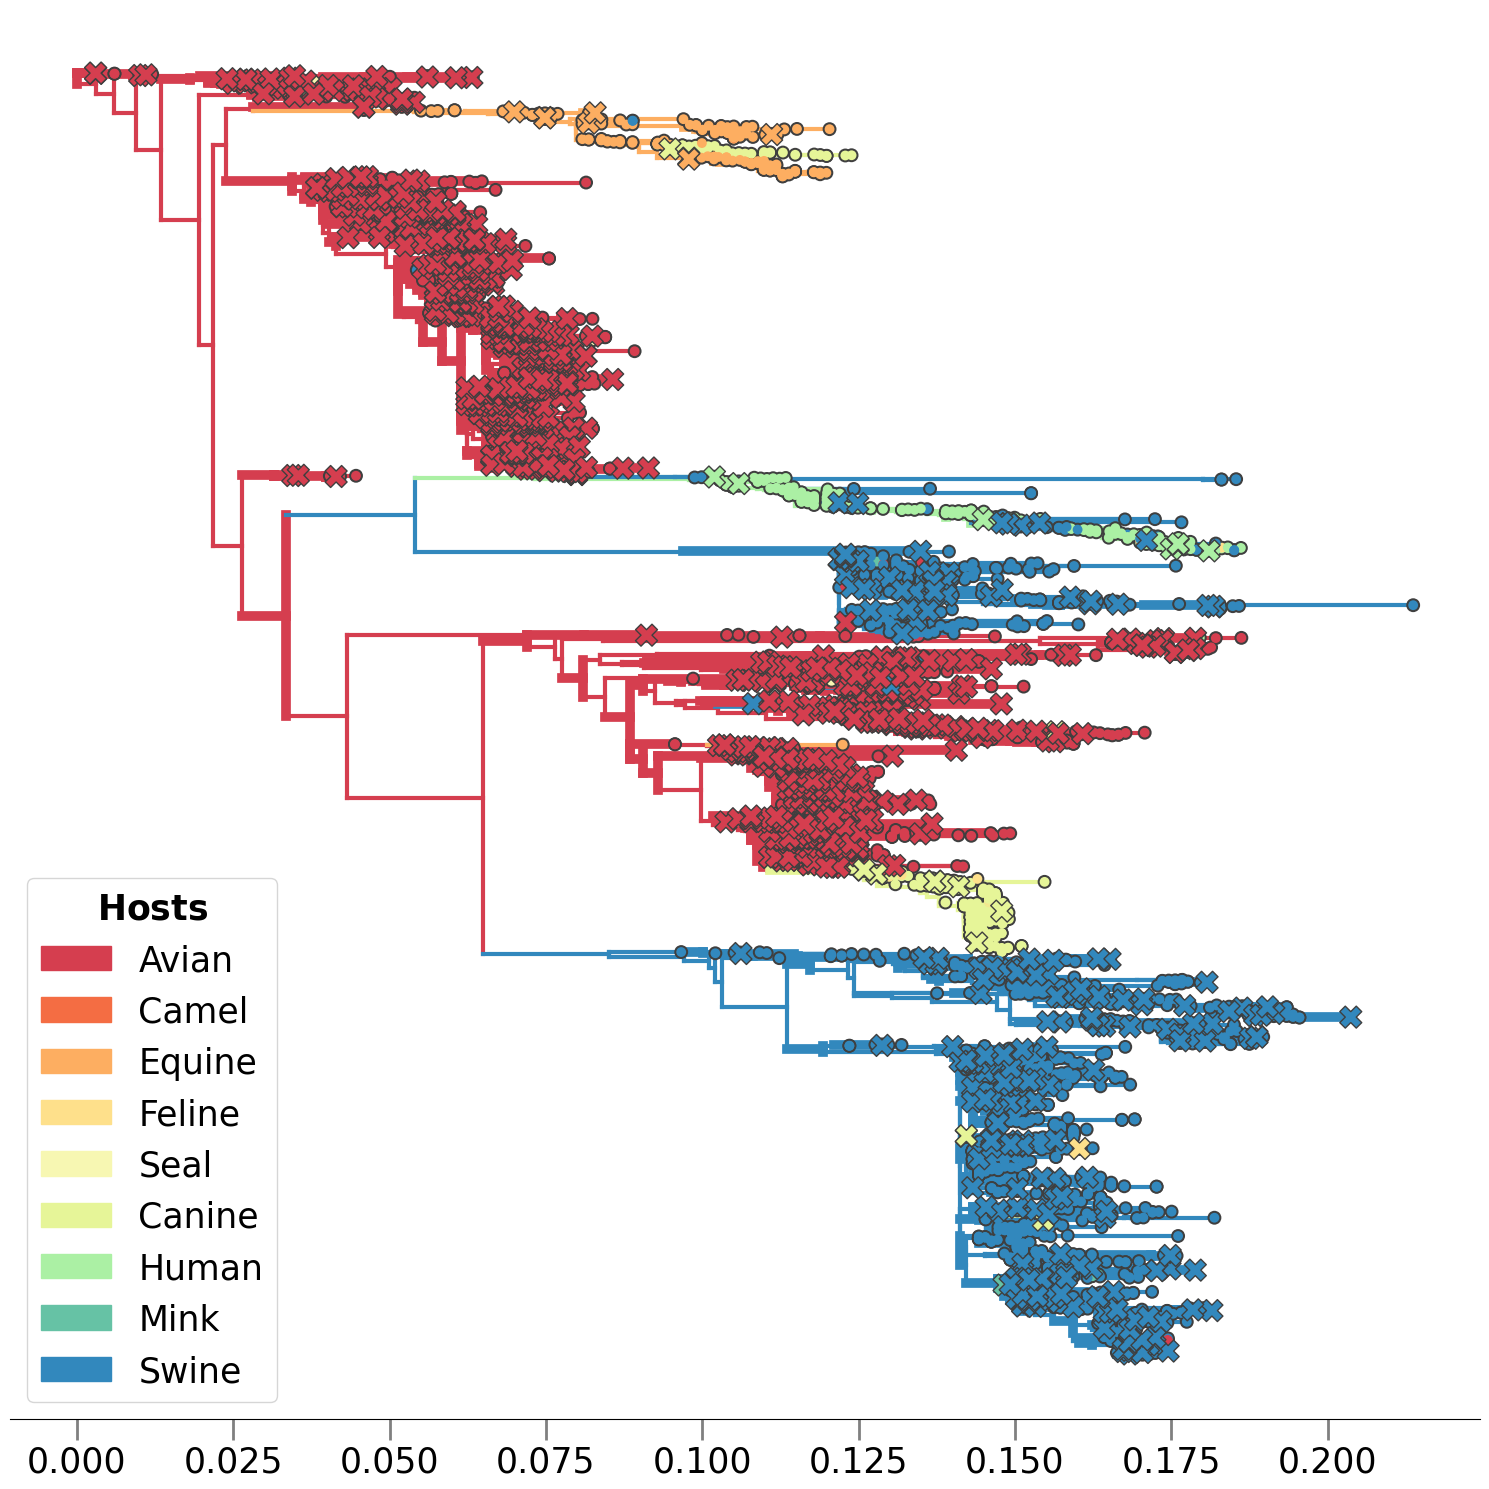

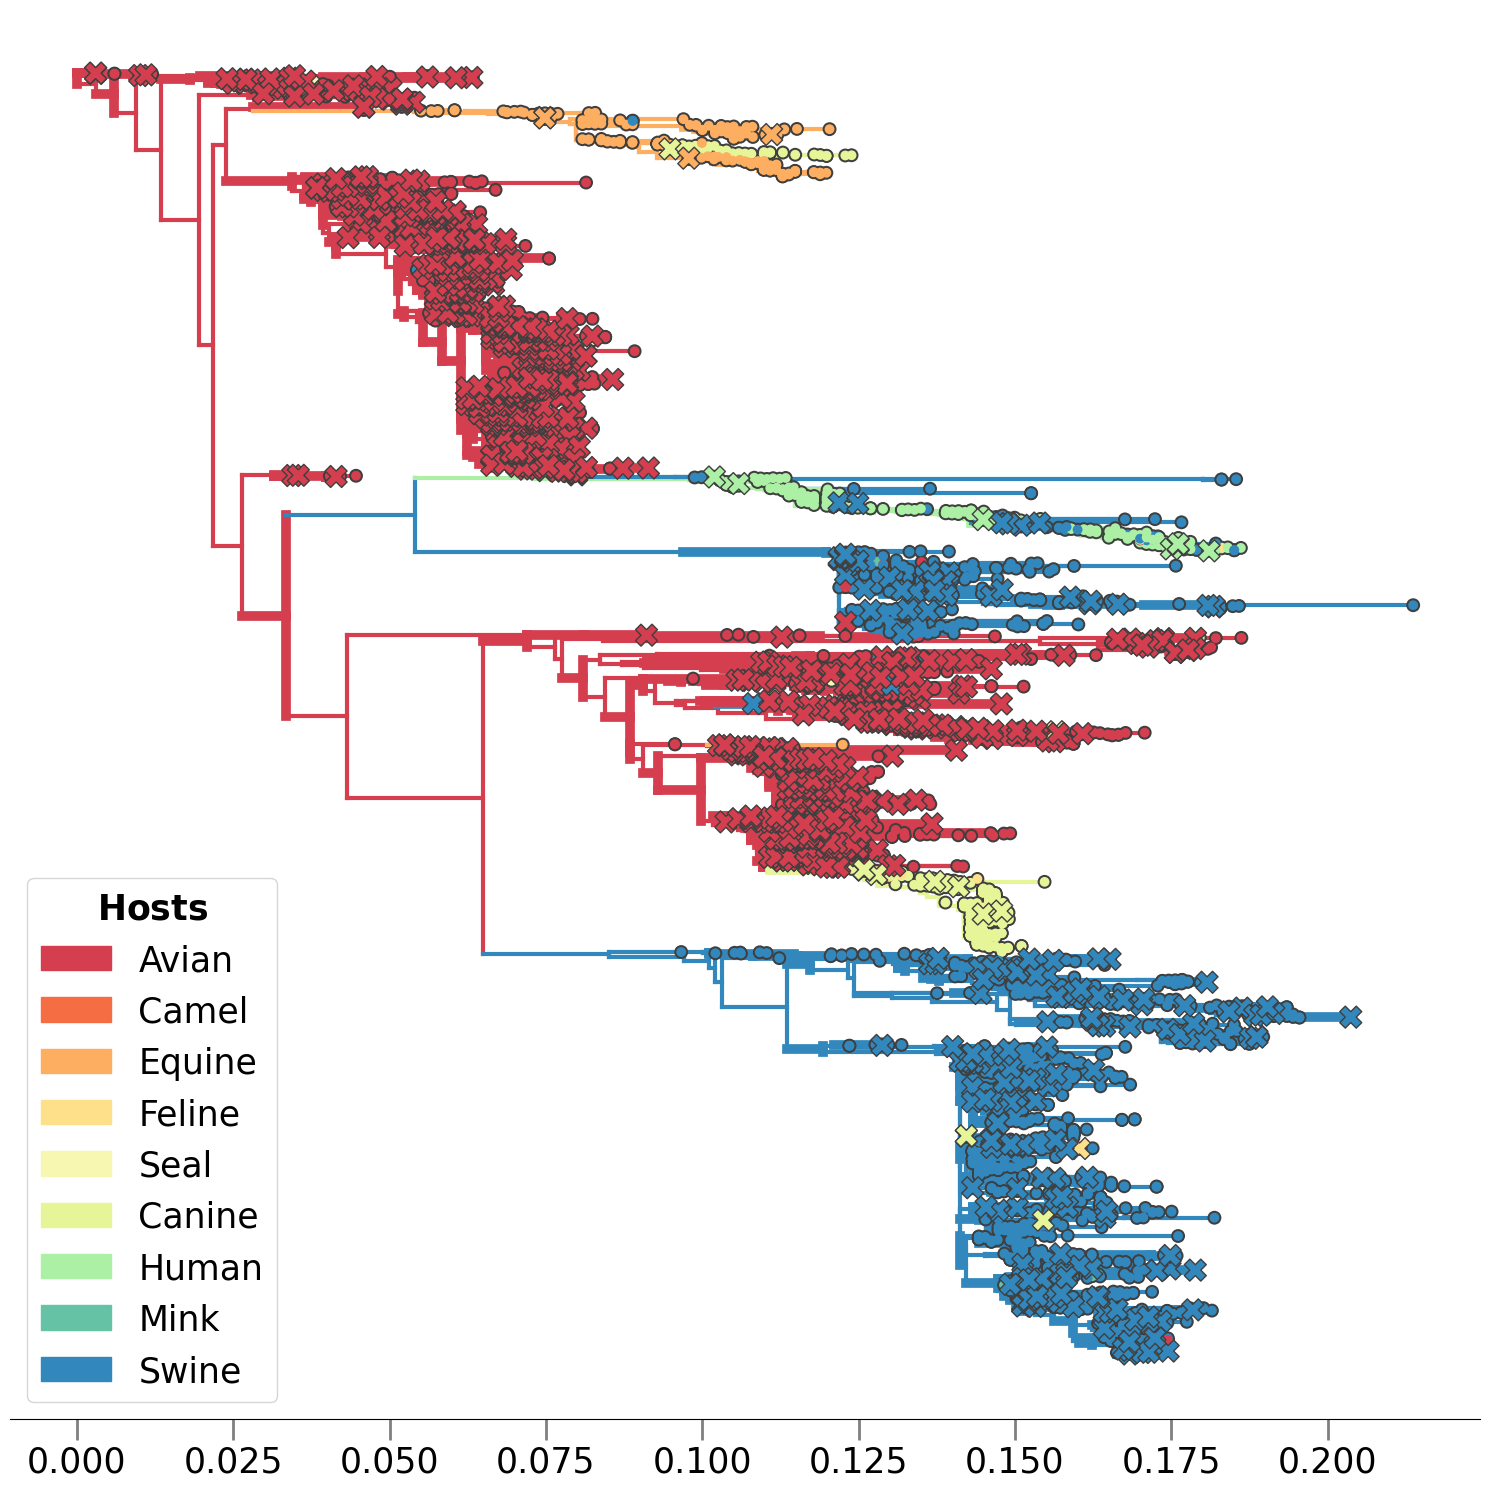

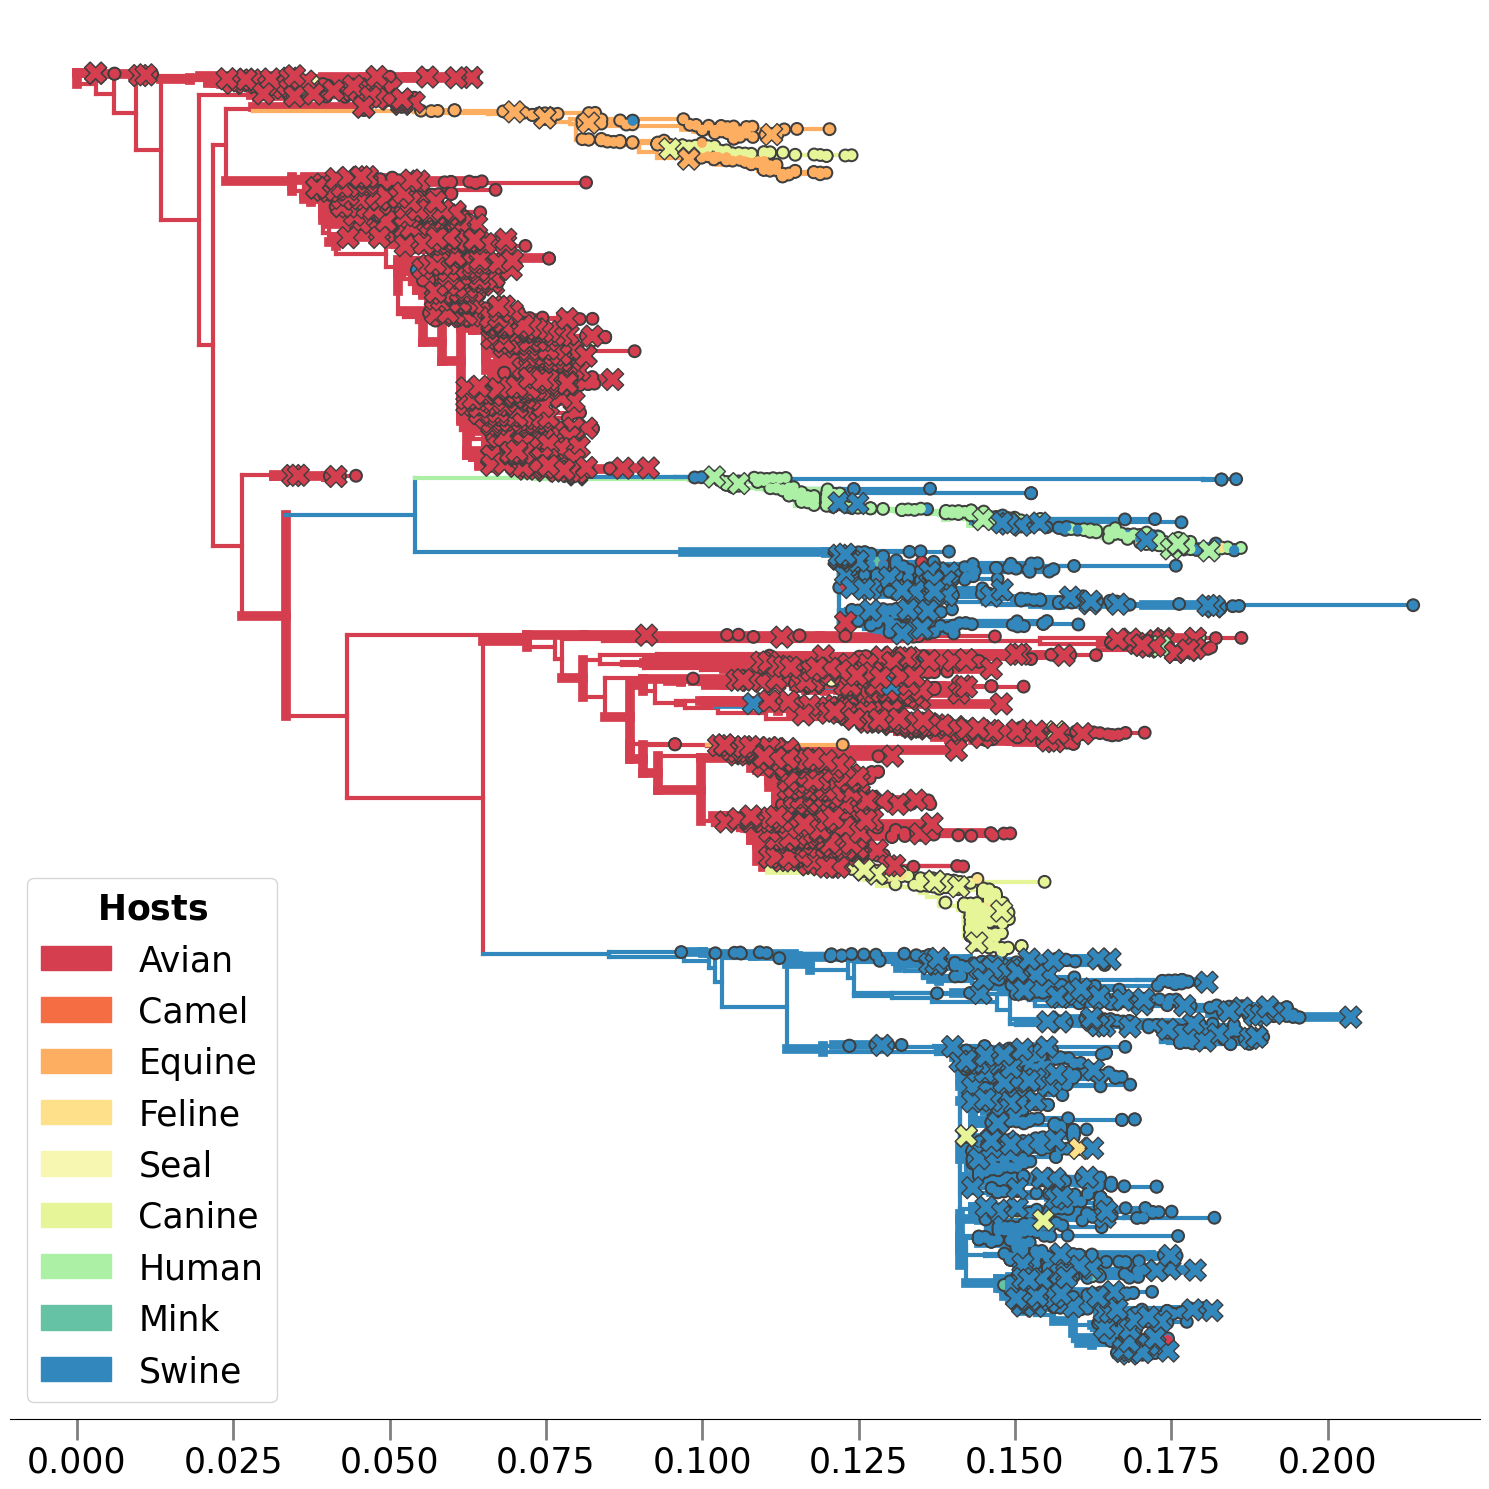

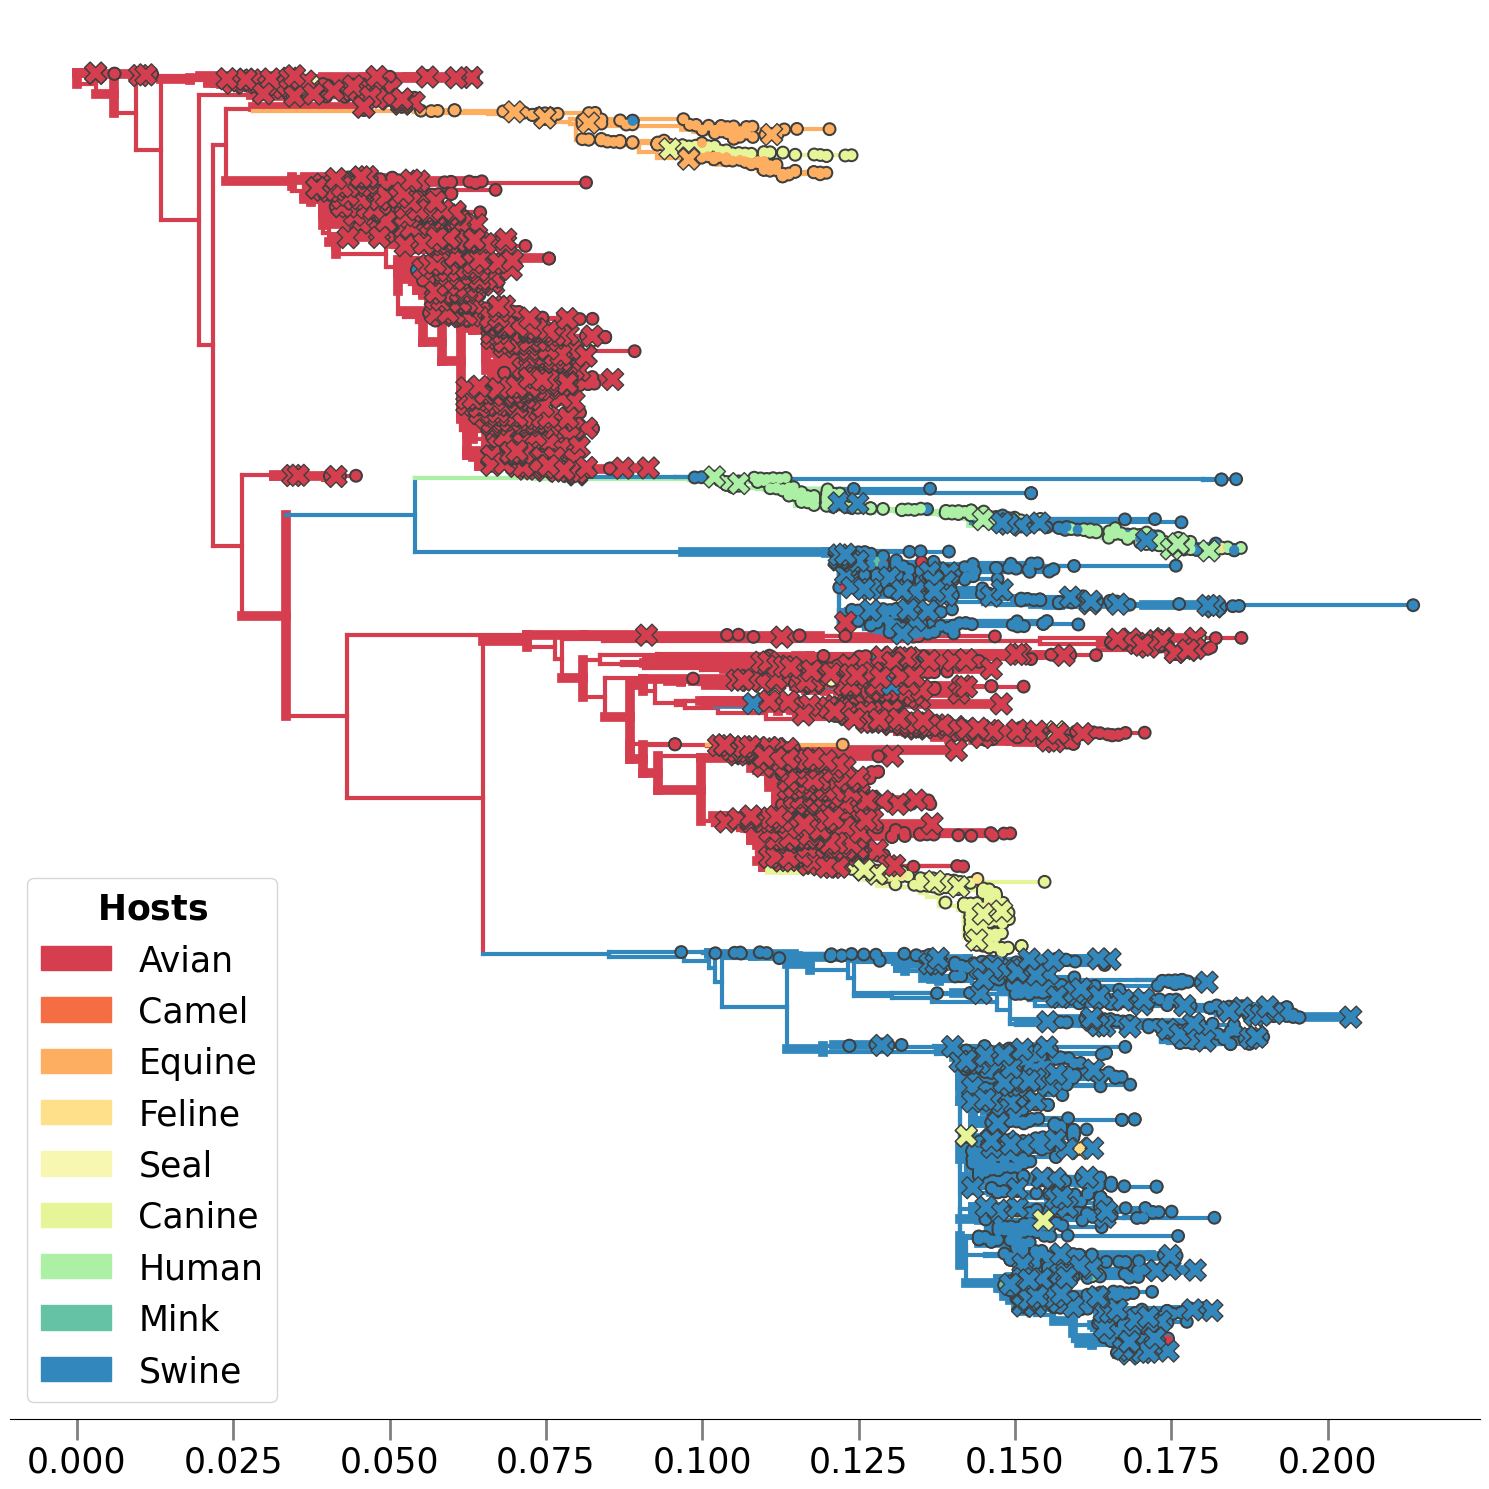

In [6]:
for name, tree in tree_dict.items():
    plot_host_reassort(tree, f"{name}/plots/whole_tree", "treesort_host.pdf")

In [7]:
reassortment_count = {}
gene_segment_counts = {name: {} for name in tree_dict.keys()}
gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'HA', 'PA']
leaf_list = {name: [] for name in tree_dict.keys()}
print(leaf_list)
nodes = {}
leaves = {}


for name, tree in tree_dict.items():
    
    leaf = []
    node_count = 0
    leaf_count = 0
    count = 0
    tree_segment_counts = {segment: 0 for segment in gene_segments}
    
    for k in tree.Objects:
        if k.traits.get('is_reassorted'):
            
            if k.is_node():
                node_count += 1
            else:
                leaf_count += 1
                leaf.append(k.name)
                
            count+=1
            
            raw_segments = k.traits["rea"]
            lst = [seg.split("(")[0] for seg in raw_segments.split("-")]
            for seg in lst:
                tree_segment_counts[seg] += 1
    
    leaf_list[name] = leaf
    reassortment_count[name] = count
    nodes[name] = node_count
    leaves[name] = leaf_count
    gene_segment_counts[name] = tree_segment_counts
    

    
print(reassortment_count)
print(nodes)
print(leaves)
pprint.pprint(gene_segment_counts)
    
# In number?
# Segments involved?
# Reassortments on leaves vs nodes
# Are the same leaves & nodes coming up as reassorted?
# Does birfurcation stay the same 

{'trees_1': [], 'trees_2': [], 'trees_3': [], 'trees_4': [], 'trees_5': []}
{'trees_1': 2296, 'trees_2': 2346, 'trees_3': 2232, 'trees_4': 2322, 'trees_5': 2291}
{'trees_1': 1102, 'trees_2': 1114, 'trees_3': 1058, 'trees_4': 1107, 'trees_5': 1090}
{'trees_1': 1194, 'trees_2': 1232, 'trees_3': 1174, 'trees_4': 1215, 'trees_5': 1201}
{'trees_1': {'HA': 511,
             'NA': 866,
             'NP': 589,
             'NS': 675,
             'PA': 620,
             'PB1': 478,
             'PB2': 621},
 'trees_2': {'HA': 526,
             'NA': 894,
             'NP': 605,
             'NS': 689,
             'PA': 657,
             'PB1': 547,
             'PB2': 628},
 'trees_3': {'HA': 480,
             'NA': 849,
             'NP': 557,
             'NS': 660,
             'PA': 583,
             'PB1': 468,
             'PB2': 561},
 'trees_4': {'HA': 500,
             'NA': 880,
             'NP': 598,
             'NS': 670,
             'PA': 616,
             'PB1': 539,
        

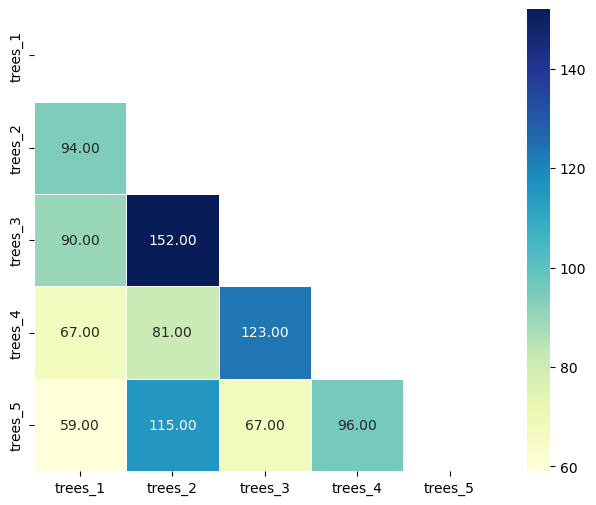

In [8]:
pairs = [(k1, k2) for idx, k1 in enumerate(leaf_list) for k2 in list(leaf_list)[idx+1:]]
differences = {}

for tree1, tree2 in pairs:
    set1 = set(leaf_list[tree1])
    set2 = set(leaf_list[tree2])
    diff = set1.symmetric_difference(set2) 
    differences[f'{tree1} vs {tree2}'] = len(diff)

heatmap_data = pd.DataFrame(index=leaf_list.keys(), columns=leaf_list.keys(), dtype=float)

for tree1, tree2 in pairs:
    diff_count = differences[f'{tree1} vs {tree2}']
    heatmap_data.at[tree1, tree2] = diff_count
    heatmap_data.at[tree2, tree1] = diff_count  # symmetric matrix, so set both ways

plt.figure(figsize=(8, 6))

# from stack overflow
mask = np.zeros_like(heatmap_data, dtype=bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False

sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True, square=True, linewidths=0.5, mask = mask)
plt.show()

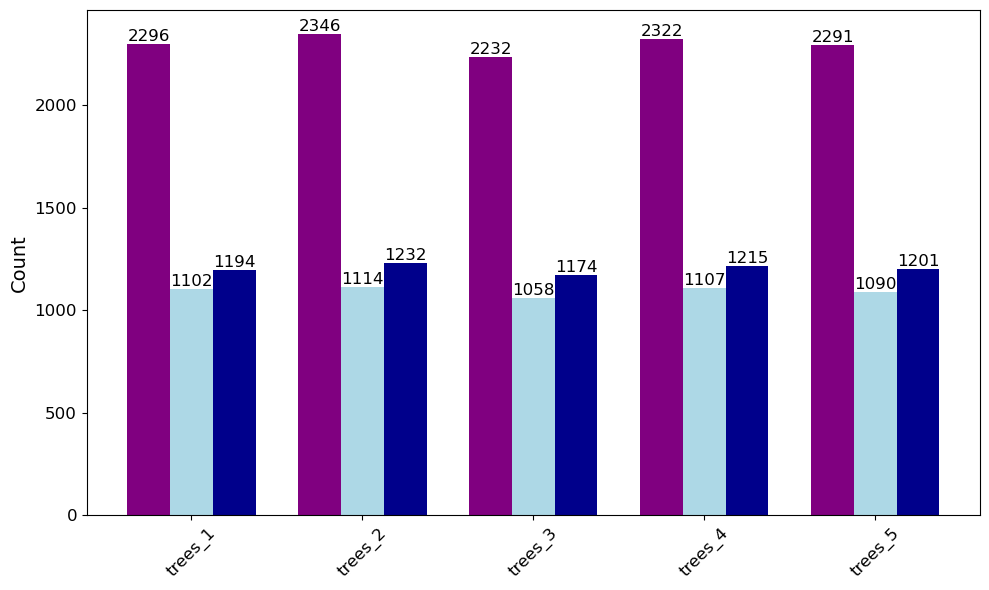

In [9]:
import numpy as np

labels = list(reassortment_count.keys())
x = np.arange(len(labels))

width = 0.25  

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, reassortment_count.values(), width, label='Reassortment Count', color='purple')
bars2 = ax.bar(x, nodes.values(), width, label='Nodes', color='lightblue')
bars3 = ax.bar(x + width, leaves.values(), width, label='Leaves', color='darkblue')

for i, bar in enumerate(bars1):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{reassortment_count[labels[i]]}', ha='center', va='bottom', fontsize=12)
for i, bar in enumerate(bars2):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{nodes[labels[i]]}', ha='center', va='bottom', fontsize=12)
for i, bar in enumerate(bars3):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
            f'{leaves[labels[i]]}', ha='center', va='bottom', fontsize=12)

ax.set_ylabel("Count", fontsize=14)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=45)

ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

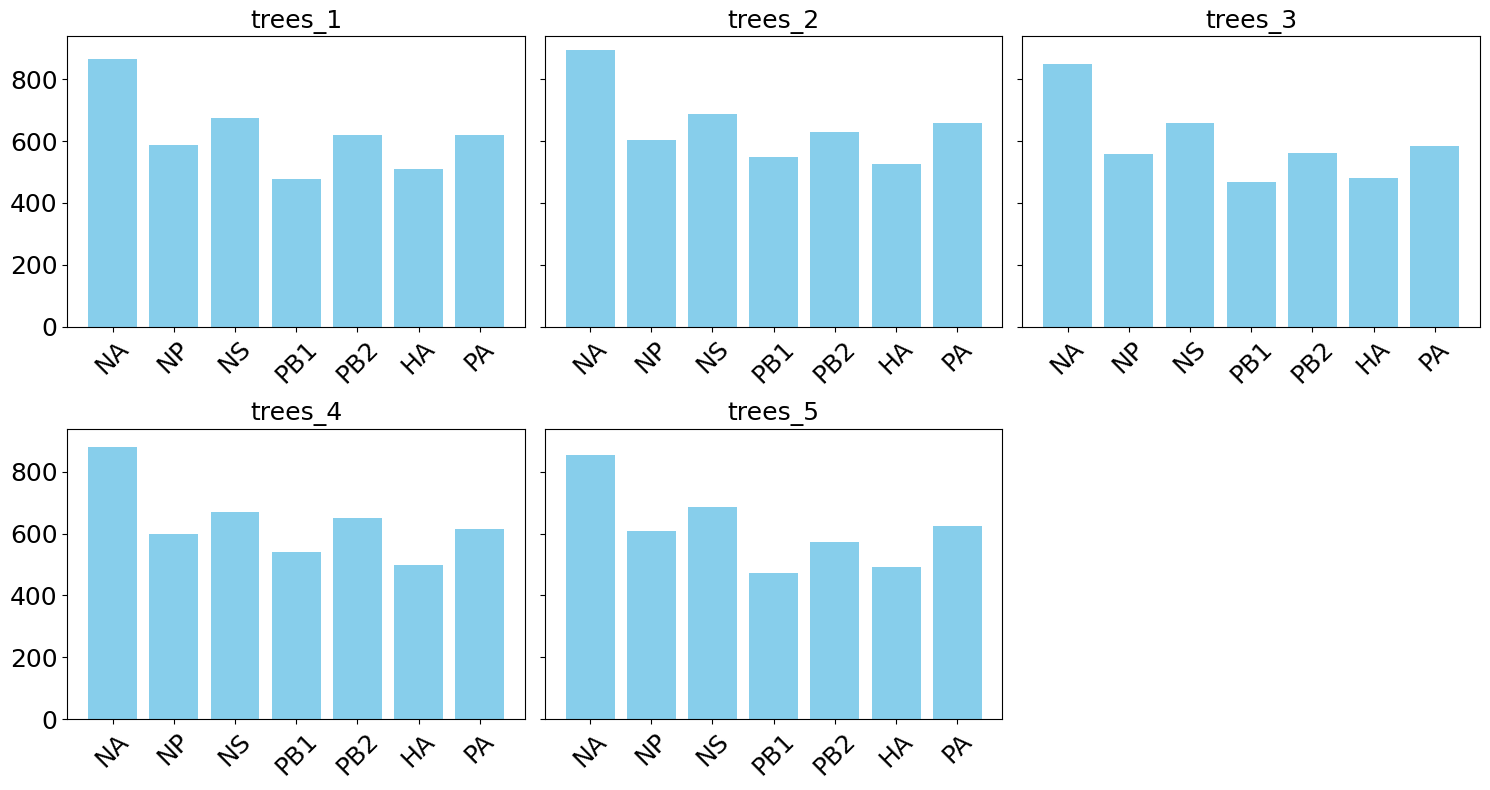

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

# Plot each dictionary in a separate subplot
for i, (tree_name, values) in enumerate(gene_segment_counts.items()):
    axes[i].bar(values.keys(), values.values(), color='skyblue')
    axes[i].set_title(tree_name, fontsize = 18)
    axes[i].set_xticks(range(len(values)))  # Set tick positions
    axes[i].set_xticklabels(values.keys(), rotation=45, fontsize=18)
    axes[i].tick_params(axis='y', labelsize=18)

# Hide the unused subplot (last one in 3x2 layout)
axes[-1].axis("off")

# Common labels and layout adjustments
plt.tight_layout()
plt.show()

In [11]:
host_order = ['Avian', 'Canine','Swine', 'Human', 'Mink', 'Seal', 'Equine', 'Camel', 'Feline']
traitName = "host"
min_leaves = 10

subtree_hosts = {name: {} for name in tree_dict.keys()}

for name, mytree in tree_dict.items():
    
    mytree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    
    host_trees={host:[] for host in host_order}

    for k in sorted(mytree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        # get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]     # kploc = trait of parental node
        else:
            kploc='ancestor'

        # print(k.traits)
        # print(f"kploc = {kploc}")
        # print(f"kloc = {kloc}") 

        # if states do not match
        if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=mytree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                clade_leaves = [leaf for leaf in subtree.getExternal() if leaf.traits[traitName] == kloc]
                if len(clade_leaves) >= min_leaves:
                    subtree.traverse_tree()
                    subtree.sortBranches()
                    host_trees[kloc].append((kploc,subtree))
                    
        subtree_hosts[name] = host_trees


In [12]:
print(subtree_hosts)

{'trees_1': {'Avian': [('ancestor', <balticEdited.tree object at 0x168e57c70>)], 'Canine': [('Equine', <balticEdited.tree object at 0x321e4c220>), ('Avian', <balticEdited.tree object at 0x3246054b0>)], 'Swine': [('Avian', <balticEdited.tree object at 0x327334670>), ('Avian', <balticEdited.tree object at 0x324e91e10>), ('Human', <balticEdited.tree object at 0x326149120>)], 'Human': [('Swine', <balticEdited.tree object at 0x14adb4970>), ('Swine', <balticEdited.tree object at 0x328348370>)], 'Mink': [], 'Seal': [], 'Equine': [('Avian', <balticEdited.tree object at 0x32427d4b0>)], 'Camel': [], 'Feline': []}, 'trees_2': {'Avian': [('ancestor', <balticEdited.tree object at 0x324ab9f90>)], 'Canine': [('Equine', <balticEdited.tree object at 0x327552650>), ('Avian', <balticEdited.tree object at 0x32e67c400>)], 'Swine': [('Avian', <balticEdited.tree object at 0x32abb65f0>), ('Avian', <balticEdited.tree object at 0x32507d420>), ('Human', <balticEdited.tree object at 0x32c2bf160>)], 'Human': [('Sw

In [13]:
host_order = ['Avian', 'Canine', 'Swine', 'Human', 'Equine']

reassortment_count = {name: {} for name in tree_dict.keys()}
gene_segment_counts = {name: {} for name in tree_dict.keys()}
nodes = {name: {} for name in tree_dict.keys()}
leaves = {name: {} for name in tree_dict.keys()}
leaf_list = {name: [] for name in tree_dict.keys()}

gene_segments = ['NA', 'NP', 'NS', 'PB1', 'PB2', 'HA', 'PA']

for name, host_trees in subtree_hosts.items(): 
    
    host_count = {host:int for host in host_order}
    host_nodes = {host:int for host in host_order}
    host_leaves = {host:int for host in host_order}
    host_segment_counts = {host:int for host in host_order}
    
    for host, subtrees in host_trees.items():
        
        if host == "Seal" or host == "Camel" or host == "Feline" or host == "Mink":
            continue  
        
        tree_segment_counts = {segment: 0 for segment in gene_segments}
        node_count = 0
        leaf_count = 0
        count = 0
        
        for _, subtree in subtrees:
            
            canine_leaves = []
             
            if host == "Canine" and _ == "Equine":
                continue
                
            for k in subtree.Objects:
                
                if k.traits.get('is_reassorted'):
            
                    if k.is_node():
                        node_count += 1
                    else:
                        leaf_count += 1
                        leaf.append(k.name)
                        if host == "Canine":
                            canine_leaves.append(k.name)

                    count+=1

                    raw_segments = k.traits["rea"]
                    lst = [seg.split("(")[0] for seg in raw_segments.split("-")]
                    for seg in lst:
                        tree_segment_counts[seg] += 1
        
        host_count[host] = count
        host_nodes[host] = node_count
        host_leaves[host] = leaf_count
        host_segment_counts[host] = tree_segment_counts
    
        if host == "Canine":
            leaf_list[name] = canine_leaves

    nodes[name] = host_nodes
    leaves[name] = host_leaves 
    gene_segment_counts[name] = host_segment_counts
    reassortment_count[name] = host_count
        
pprint.pprint(reassortment_count)
pprint.pprint(gene_segment_counts)
pprint.pprint(leaves)
pprint.pprint(nodes)
# pprint.pprint(leaf_list)
                

{'trees_1': {'Avian': 1835,
             'Canine': 10,
             'Equine': 10,
             'Human': 14,
             'Swine': 410},
 'trees_2': {'Avian': 1872,
             'Canine': 12,
             'Equine': 13,
             'Human': 14,
             'Swine': 417},
 'trees_3': {'Avian': 1790,
             'Canine': 10,
             'Equine': 7,
             'Human': 14,
             'Swine': 395},
 'trees_4': {'Avian': 1854,
             'Canine': 12,
             'Equine': 11,
             'Human': 14,
             'Swine': 413},
 'trees_5': {'Avian': 1827,
             'Canine': 11,
             'Equine': 11,
             'Human': 14,
             'Swine': 411}}
{'trees_1': {'Avian': {'HA': 395,
                       'NA': 700,
                       'NP': 482,
                       'NS': 554,
                       'PA': 526,
                       'PB1': 387,
                       'PB2': 531},
             'Canine': {'HA': 0,
                        'NA': 3,
              

In [14]:
unique_strains = set()
for strains in leaf_list.values():
    unique_strains.update(strains)

with open('mp_canine_leaves.txt', 'w') as f:
    for strain in sorted(unique_strains):  # sorted() is optional if you want it ordered
        f.write(f"{strain}\n")

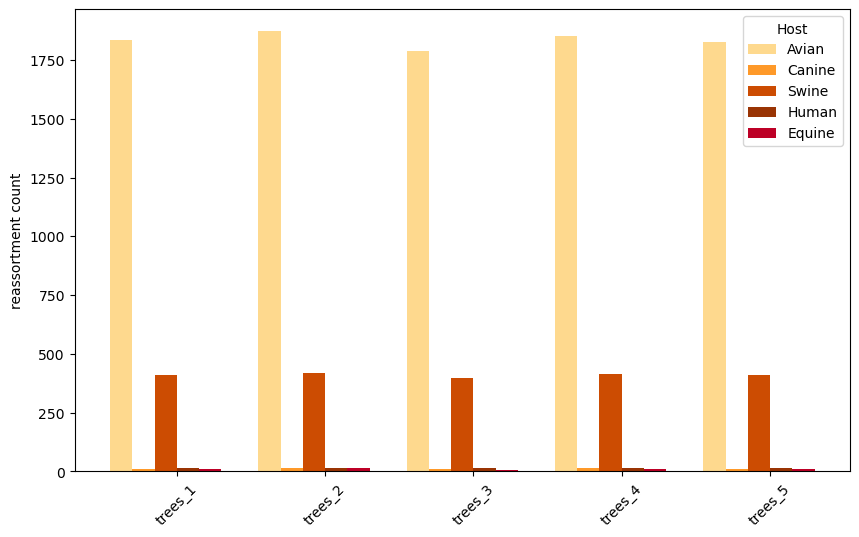

In [32]:

trees = list(reassortment_count.keys())
hosts = list(next(iter(reassortment_count.values())).keys())  # Extract host categories

bar_width = 0.15 
x = np.arange(len(trees))

colors = ['#fed98e', '#fe9929', '#cc4c02', '#993404', '#bd0026']
host_colors = dict(zip(hosts, colors))

fig, ax = plt.subplots(figsize=(10, 6))

for i, host in enumerate(hosts):
    values = [reassortment_count[tree][host] for tree in trees]
    ax.bar(x + i * bar_width, values, bar_width, label=host, color=host_colors[host])

ax.set_ylabel('reassortment count')
ax.set_xticks(x + bar_width * (len(hosts) / 2))  # Centering x-ticks
ax.set_xticklabels(trees, rotation=45)
ax.legend(title="Host")
plt.show()


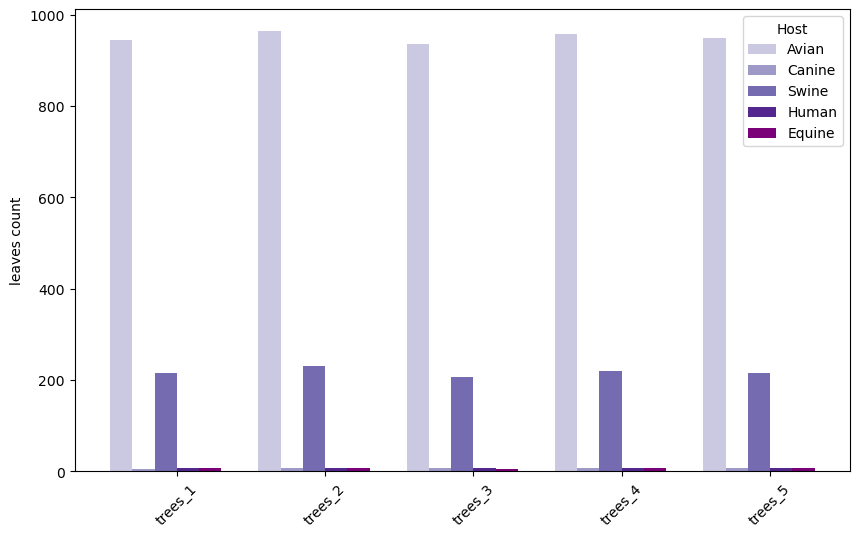

In [33]:

trees = list(leaves.keys())
hosts = list(next(iter(leaves.values())).keys())  # Extract host categories


bar_width = 0.15 
x = np.arange(len(trees))  

colors = ['#cbc9e2', '#9e9ac8', '#756bb1', '#54278f', '#7a0177']

host_colors = dict(zip(hosts, colors))


fig, ax = plt.subplots(figsize=(10, 6))


for i, host in enumerate(hosts):
    values = [leaves[tree][host] for tree in trees]
    ax.bar(x + i * bar_width, values, bar_width, label=host, color=host_colors[host])


ax.set_ylabel('leaves count')
ax.set_xticks(x + bar_width * (len(hosts) / 2))  # Centering x-ticks
ax.set_xticklabels(trees, rotation=45)
ax.legend(title="Host")
plt.show()


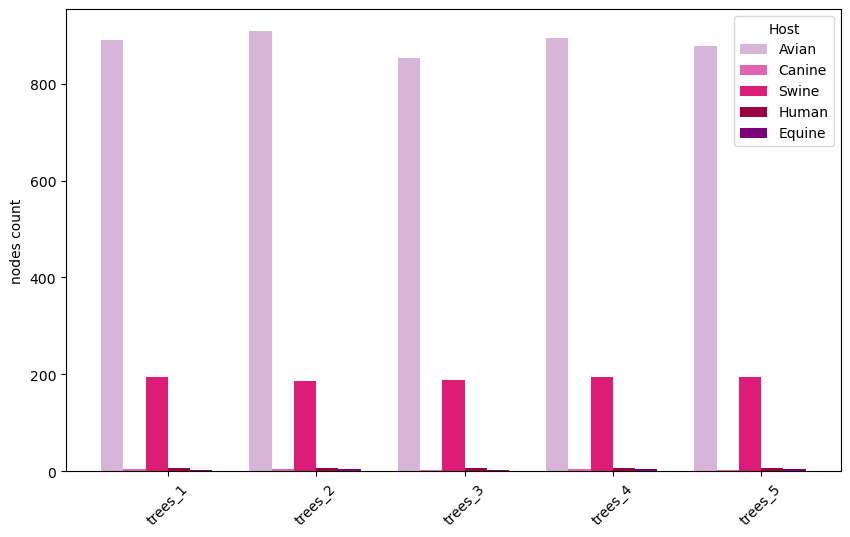

In [34]:

# Convert dictionary to lists
trees = list(nodes.keys())
hosts = list(next(iter(nodes.values())).keys())  # Extract host categories

# Prepare data for plotting
bar_width = 0.15  # Width of each bar
x = np.arange(len(trees))  # X positions for groups of bars

# Define colors for each host
colors = ['#d7b5d8', '#df65b0', '#dd1c77', '#980043', '#7a0177']
host_colors = dict(zip(hosts, colors))

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each host as a separate bar series
for i, host in enumerate(hosts):
    values = [nodes[tree][host] for tree in trees]
    ax.bar(x + i * bar_width, values, bar_width, label=host, color=host_colors[host])

# Formatting
ax.set_ylabel('nodes count')
ax.set_xticks(x + bar_width * (len(hosts) / 2))  # Centering x-ticks
ax.set_xticklabels(trees, rotation=45)
ax.legend(title="Host")
plt.show()


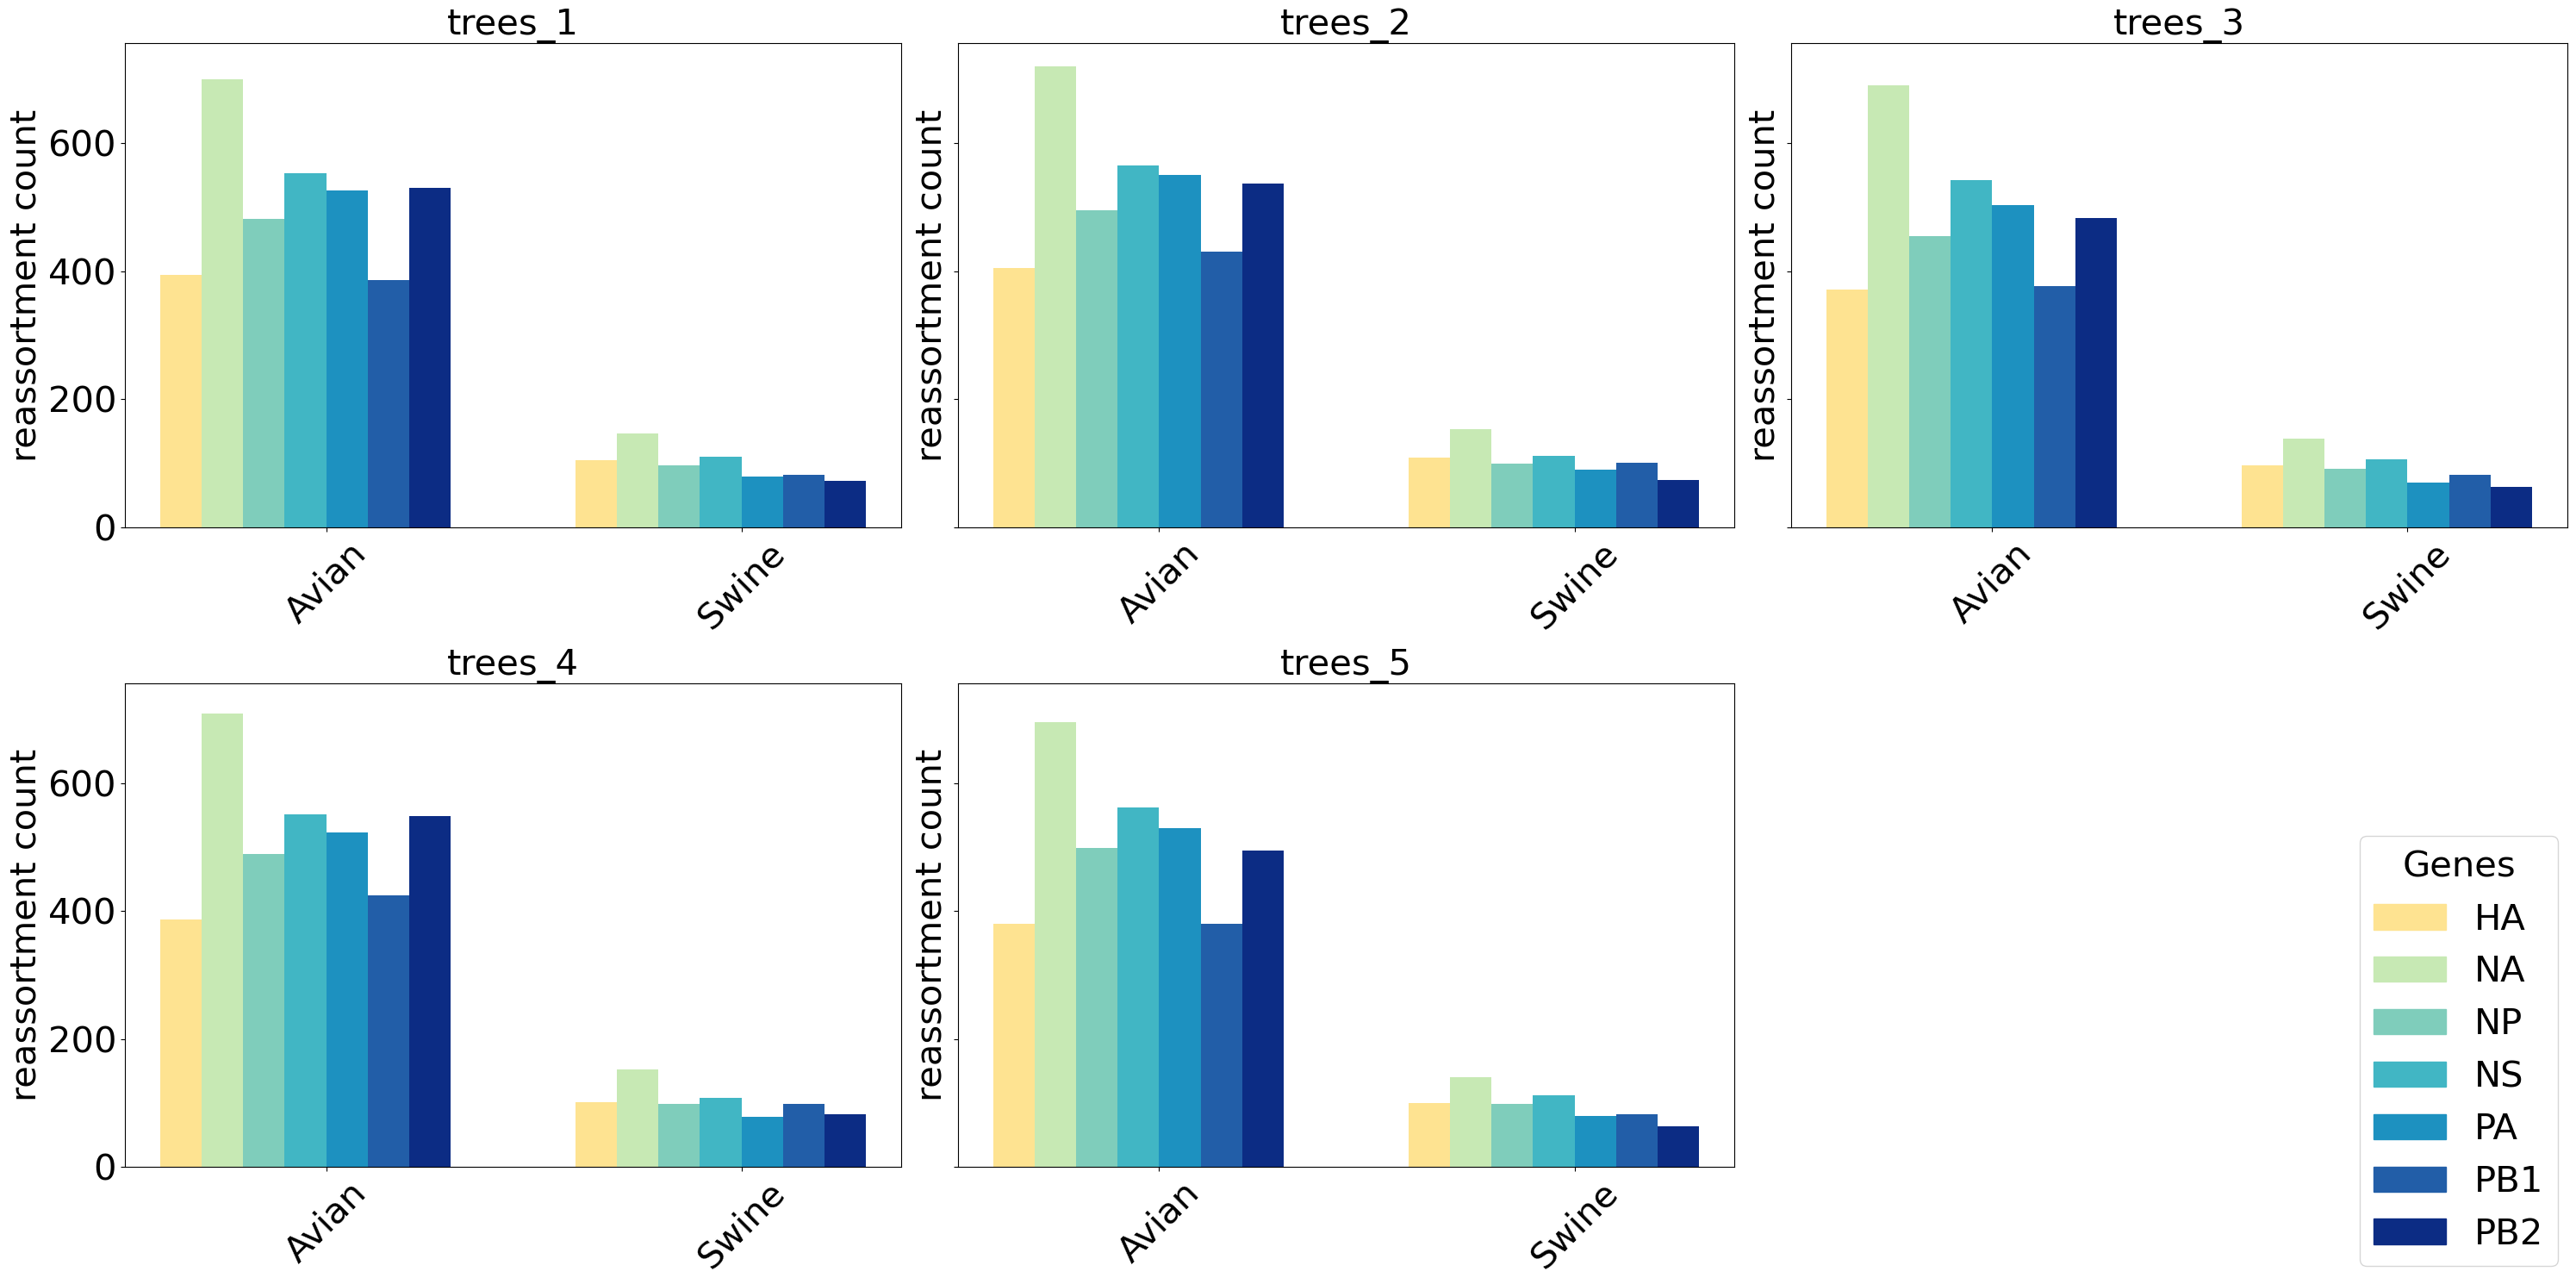

In [35]:
trees = list(gene_segment_counts.keys())

genes = ['HA', 'NA', 'NP', 'NS', 'PA', 'PB1', 'PB2']
hosts = ['Avian', 'Swine']
colors = ['#fee391', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']  # Colors for genes

# Create separate plots for each tree
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15), sharey=True)

axes = axes.flatten()
axes[-1].set_visible(False)

for idx, tree in enumerate(trees):
    ax = axes[idx]
    x = np.arange(len(hosts))  # X positions for the hosts

    # Plot each gene as a different colored bar for each host
    bar_width = 0.1
    for i, gene in enumerate(genes):
        values = [gene_segment_counts[tree][host][gene] for host in hosts]
        ax.bar(x + i * bar_width, values, bar_width, label=gene, color=colors[i])

    ax.set_title(tree, fontsize=30)
    ax.set_xticks(x + bar_width * (len(genes) / 2))
    ax.set_xticklabels(hosts, rotation=45, fontsize=30)
    ax.set_ylabel('reassortment count', fontsize = 30)
    ax.tick_params(axis='y', labelsize=30)


# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(genes))]
fig.legend(handles, genes, title="Genes", loc="lower right",fontsize=30, title_fontsize=30)

plt.tight_layout()
plt.show()

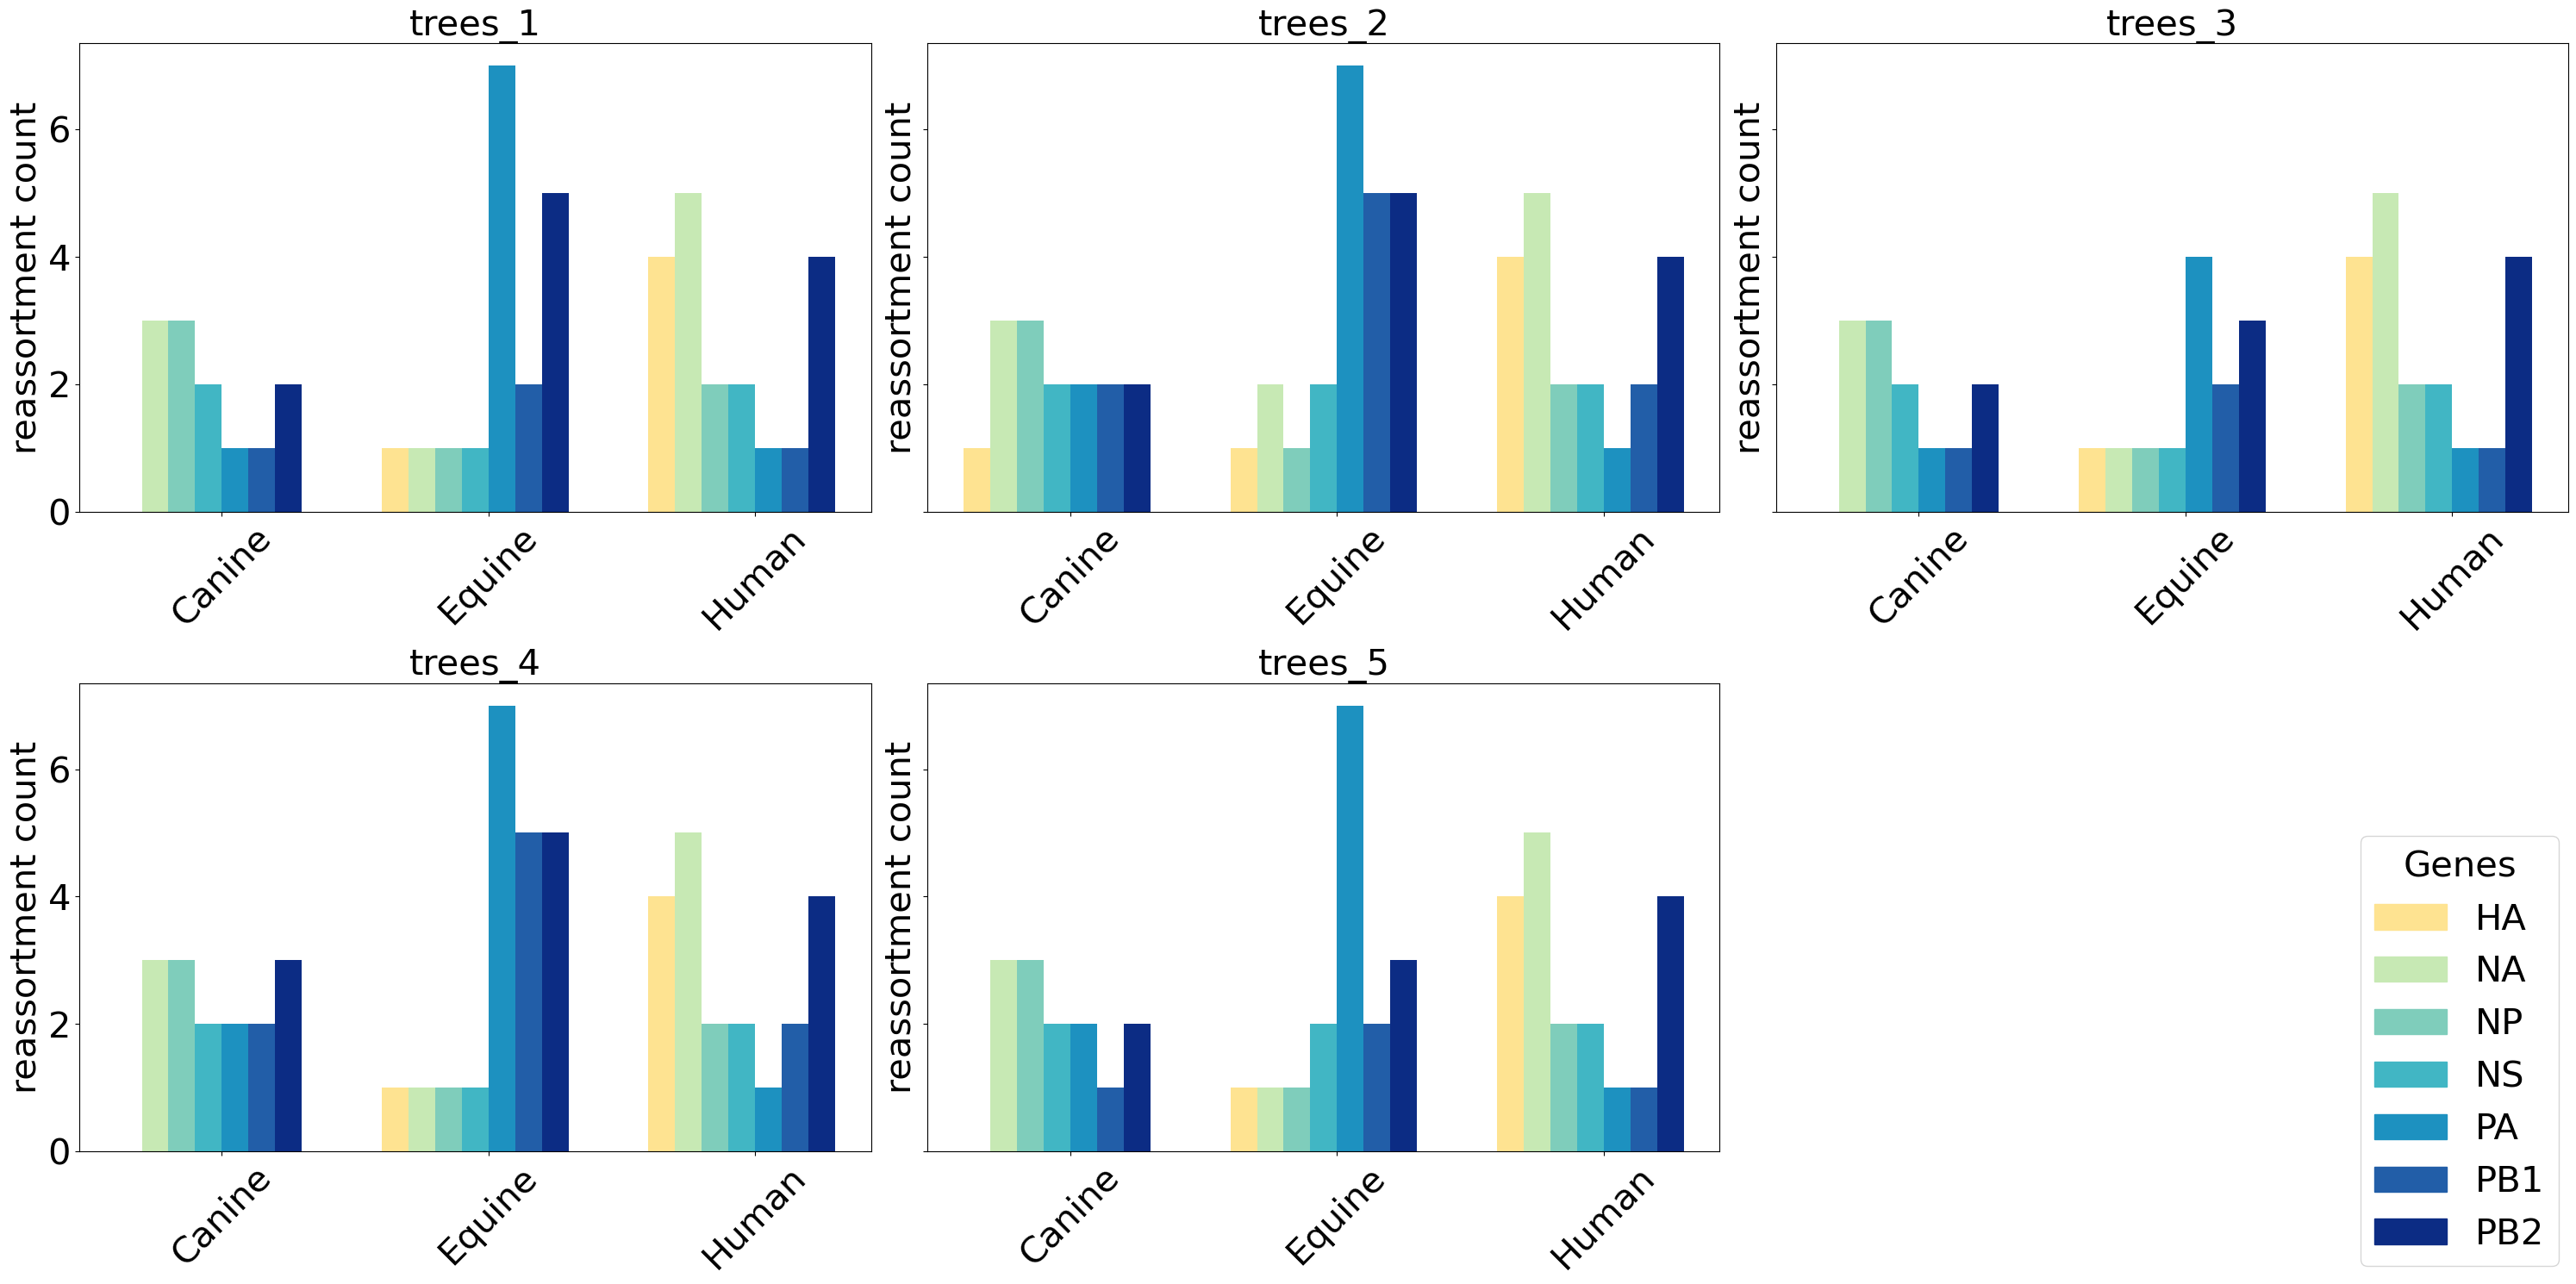

In [36]:
trees = list(gene_segment_counts.keys())

genes = ['HA', 'NA', 'NP', 'NS', 'PA', 'PB1', 'PB2']
hosts = ['Canine', 'Equine', 'Human']
colors = ['#fee391', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#0c2c84']  # Colors for genes

# Create separate plots for each tree
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 15), sharey=True)

axes = axes.flatten()
axes[-1].set_visible(False)

for idx, tree in enumerate(trees):
    ax = axes[idx]
    x = np.arange(len(hosts))  # X positions for the hosts

    # Plot each gene as a different colored bar for each host
    bar_width = 0.1
    for i, gene in enumerate(genes):
        values = [gene_segment_counts[tree][host][gene] for host in hosts]
        ax.bar(x + i * bar_width, values, bar_width, label=gene, color=colors[i])

    ax.set_title(tree, fontsize=30)
    ax.set_xticks(x + bar_width * (len(genes) / 2))
    ax.set_xticklabels(hosts, rotation=45, fontsize=30)
    ax.set_ylabel('reassortment count', fontsize = 30)
    ax.tick_params(axis='y', labelsize=30)


# Add shared legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(genes))]
fig.legend(handles, genes, title="Genes", loc="lower right",fontsize=30, title_fontsize=30)

plt.tight_layout()
plt.show()